In [36]:
# data analysis imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# preprocessing imports
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# read the fake job postings dataset
df = pd.read_csv('fake_job_postings.csv')

In [37]:
# returns the first 5 rows
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [38]:
# describes the numerical features of our dataset
df.describe()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent
count,17880.000000,17880.000000,17880.000000,17880.000000,17880.000000
mean,8940.500000,0.042897,0.795302,0.491723,0.048434
std,5161.655742,0.202631,0.403492,0.499945,0.214688
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4470.750000,0.000000,1.000000,0.000000,0.000000
50%,8940.500000,0.000000,1.000000,0.000000,0.000000
75%,13410.250000,0.000000,1.000000,1.000000,0.000000
max,17880.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# check for features where missing values are high
# note: we see that salary_range has significant number of NaN want to remove that, otherwise it will create noise
df.isna().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [40]:
# check for duplicates
# no duplicates, so no need to handle them
df.duplicated().sum()

np.int64(0)

Text(0.5, 0, 'Fradulent (0 = No, 1 = Yes)')

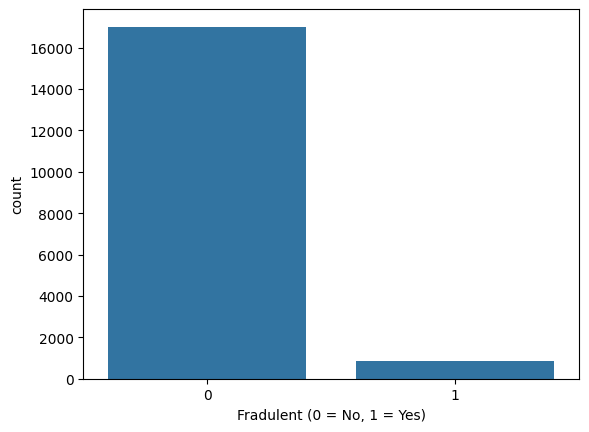

In [41]:
# plot bar chat for rows that are fraudulent
# dataset is imbalanced, will fix soon
sns.countplot(x='fraudulent', data=df)
df['fraudulent'].value_counts()
x_label = "Fradulent (0 = No, 1 = Yes)"
plt.xlabel(x_label)


In [ ]:
# (look at df.isna().sum() code above for reference)
# drop job_id because it doesn't hold any value to our model, only serves a unique identifier
# drop salary_range because it has a significant amount of missing values(NaN) which can affect model performance and complicate preprocessing with its noise
columns = ['job_id', 'salary_range']

for col in columns:
    del df[col]

# Fill the 'NaN' fields in our dataset to avoid errors when dealing with TF-IDF or our models
df.fillna('unknown', inplace=True)
df.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,Marketing Intern,"US, NY, New York",Marketing,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,unknown,0,1,0,Other,Internship,unknown,unknown,Marketing,0
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,unknown,Marketing and Advertising,Customer Service,0
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",unknown,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,unknown,0,1,0,unknown,unknown,unknown,unknown,unknown,0
3,Account Executive - Washington DC,"US, DC, Washington",Sales,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,Bill Review Manager,"US, FL, Fort Worth",unknown,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
# generate stop words to clean our text
stop_words = set(stopwords.words('english'))

# add the punctuation list to the set of stop words
punctuation = list(string.punctuation)
stop_words.update(punctuation)

# initialize our lemmatizer
lemmatizer = WordNetLemmatizer()

<class 'set'>


In [ ]:
# combine the columns/features for TF-IDF to predict fraudulent
df['text'] = df['title'] + " " + df['location'] + " " + df['department'] + " " + df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits'] + " " + df['employment_type'] + " " + df['required_experience'] + " " +df['required_education'] + " " + df['industry'] + " " + df['function']

# reduce dataset dimensionality 
del_column = ['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'employment_type', 'required_experience', 'required_education', 'industry', 'function']

# delete the columns/features
for col in del_column: 
    del df[col]

In [ ]:
def preprocess_text(text):
    '''
    Uses stopwords and lemmatizing to clean the text
     
    Parameters
    ----------
    text: the combined text of all our features
    '''

    # tokenize the text
    tokens = word_tokenize(text.lower())
    # Remove stop words and non-alphabetic tokens and lemmantize
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]

    return ' '.join(tokens)

# apply preprocessing and add new ['text_processed] feature
df['text_processed'] = df['text'].apply(preprocess_text)

In [46]:
df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,text,text_processed
0,0,1,0,0,"Marketing Intern US, NY, New York Marketing We...",marketing intern u ny new york marketing creat...
1,0,1,0,0,"Customer Service - Cloud Video Production NZ, ...",customer service cloud video production nz auc...
2,0,1,0,0,"Commissioning Machinery Assistant (CMA) US, IA...",commissioning machinery assistant cma u ia wev...
3,0,1,0,0,"Account Executive - Washington DC US, DC, Wash...",account executive washington dc u dc washingto...
4,0,1,1,0,"Bill Review Manager US, FL, Fort Worth unknown...",bill review manager u fl fort worth unknown sp...


In [47]:
# split into train/test sets using 20% for test
trainX, testX, trainy, testy = train_test_split(df['text_processed'], df['fraudulent'], test_size = 0.2, random_state=0)

In [ ]:
# instantiate the vectorizer object
# min_df, max_df just includes all the text, already removed stopwords at preprocess
# ngram to pick up important phrases or patterns, (1,3) for like at most 3-words
tfidf_vectorizer = TfidfVectorizer(min_df=0.0, max_df=1.0, analyzer='word', ngram_range=(1,3))
# convert the training set into a matrix.
tfidf_train = tfidf_vectorizer.fit_transform(trainX)
# convert the test set into a matrix.
tfidf_test = tfidf_vectorizer.transform(testX)